**Weekend Business Activity Zones in Melbourne**

**Authored by**: SAHITHI PINNAM

**Duration**: 90 mins

**Level**: Intermediate

**Pre-requisite Skills**: Python, Pandas, NumPy, Matplotlib, Folium (basic geospatial)

**Scenario**

As a business owner or city economic planner in Melbourne, I want to identify where weekend pedestrian activity is highest and where businesses are concentrated, so I can plan opening hours, promotions, staffing, and events to match weekend demand.

As a planner/analyst, I want named examples of nearby hospitality venues (cafés/restaurants) around the busiest zones to ground decisions in real places.

**What this use case will teach you**

By the end of this use case you will have:

Pulled multiple City of Melbourne datasets with the API v2.1.
Cleaned, filtered, and merged business + pedestrian data for weekend analysis.
Performed distance-based proximity joins (≤200 m).
Built a bar chart of top weekend hotspots and an interactive map with business counts and named cafés.
Written business-oriented insights and recommendations.

**Introduction**

Weekend activity in Melbourne is driven by retail, hospitality, leisure, and events. This project focuses on where people go on weekends and what businesses are nearby. We combine pedestrian sensors (for weekend footfall) with business locations and a named cafés dataset to deliver actionable guidance for Business & Economy stakeholders.

**Datasets used**

Business Establishments with Address and Industry Classification [https://data.melbourne.vic.gov.au/explore/dataset/business-establishments-with-address-and-industry-classification/information/?disjunctive.industry_anzsic4_description&disjunctive.block_id&disjunctive.clue_small_area&disjunctive.industry_anzsic4_code]
Identifier: business-establishments-with-address-and-industry-classification
Use: overall business density near hotspots (counts within 200 m).

Cafes and Restaurants with Seating Capacity[https://data.melbourne.vic.gov.au/explore/dataset/cafes-and-restaurants-with-seating-capacity/information/?disjunctive.block_id&disjunctive.industry_anzsic4_code&disjunctive.industry_anzsic4_description&disjunctive.number_of_seats&disjunctive.clue_small_area]
Identifier: cafes-and-restaurants-with-seating-capacity
Use: named venues (examples) near hotspots to enrich business context.

Pedestrian Counting System – Monthly counts per hour[https://data.melbourne.vic.gov.au/explore/?q=1.%09Pedestrian+Counting+System+–+Monthly+counts+per+hour&sort=modified]
Identifier: pedestrian-counting-system-monthly-counts-per-hour
Use: hourly counts; filter Saturday/Sunday and aggregate by sensor.

Pedestrian Counting System – Sensor locations[https://data.melbourne.vic.gov.au/explore/dataset/pedestrian-counting-system-sensor-locations/information/]
Identifier: pedestrian-counting-system-sensor-locations
Use: coordinates for each sensor to map and compute distances.

**Importing Datasets**

This section imports libraries for data manipulation, visualisation, simple geospatial operations, and API access.

In [1]:
# Libraries
import pandas as pd
import numpy as np
import requests, io, os
import matplotlib.pyplot as plt
import folium

pd.set_option("display.max_colwidth", 200)


**Loading the datasets using API v2.1**

We define a helper to fetch full CSV exports from the City of Melbourne API v2.1.

In [2]:
def fetch_dataset_csv(base_url, dataset, api_key=None):
    suffix = 'exports/csv?delimiter=%3B&list_separator=%2C&quote_all=false&with_bom=true'
    url = f"{base_url}{dataset}/{suffix}"
    params = {'api_key': api_key} if api_key else {}
    r = requests.get(url, params=params, timeout=30)
    r.raise_for_status()
    return pd.read_csv(io.BytesIO(r.content), delimiter=';')


**Fetching and Previewing Datasets**

We’ll load the four datasets and quickly preview shapes and columns.

In [3]:
# Config
API_KEY = os.environ.get('MELBOURNE_API_KEY', '')
BASE_URL = 'https://data.melbourne.vic.gov.au/api/explore/v2.1/catalog/datasets/'

DATASETS = {
    "business": "business-establishments-with-address-and-industry-classification",
    "cafes": "cafes-and-restaurants-with-seating-capacity",
    "pedestrian": "pedestrian-counting-system-monthly-counts-per-hour",
    "locations": "pedestrian-counting-system-sensor-locations"
}

# Load
business_df  = fetch_dataset_csv(BASE_URL, DATASETS["business"], API_KEY)
cafes_df     = fetch_dataset_csv(BASE_URL, DATASETS["cafes"], API_KEY)
ped_df       = fetch_dataset_csv(BASE_URL, DATASETS["pedestrian"], API_KEY)
loc_df       = fetch_dataset_csv(BASE_URL, DATASETS["locations"], API_KEY)

print("Business columns:", business_df.columns.tolist()[:12], "... | rows:", len(business_df))
print("Cafes columns   :", cafes_df.columns.tolist()[:12],    "... | rows:", len(cafes_df))
print("Ped columns     :", ped_df.columns.tolist()[:12],      "... | rows:", len(ped_df))
print("Loc columns     :", loc_df.columns.tolist()[:12],      "... | rows:", len(loc_df))


Business columns: ['census_year', 'block_id', 'property_id', 'base_property_id', 'clue_small_area', 'trading_name', 'business_address', 'industry_anzsic4_code', 'industry_anzsic4_description', 'longitude', 'latitude', 'point'] ... | rows: 393878
Cafes columns   : ['census_year', 'block_id', 'property_id', 'base_property_id', 'building_address', 'clue_small_area', 'trading_name', 'business_address', 'industry_anzsic4_code', 'industry_anzsic4_description', 'seating_type', 'number_of_seats'] ... | rows: 63121
Ped columns     : ['id', 'location_id', 'sensing_date', 'hourday', 'direction_1', 'direction_2', 'pedestriancount', 'sensor_name', 'location'] ... | rows: 1390468
Loc columns     : ['location_id', 'sensor_description', 'sensor_name', 'installation_date', 'note', 'location_type', 'status', 'direction_1', 'direction_2', 'latitude', 'longitude', 'location'] ... | rows: 143


**Displaying Dataset Overview**

We focus on columns needed for business-first analysis: names (for cafés), coordinates, and pedestrian counts.

In [4]:
business_df = business_df.copy()
cafes_df    = cafes_df.copy()
ped_df      = ped_df.copy()
loc_df      = loc_df.copy()

# Standardise coordinates to numeric
for df in (business_df, cafes_df, loc_df):
    if 'latitude' in df.columns:
        df['latitude']  = pd.to_numeric(df['latitude'], errors='coerce')
    if 'longitude' in df.columns:
        df['longitude'] = pd.to_numeric(df['longitude'], errors='coerce')

# Cafes: normalise name column if present
name_cols = [c for c in cafes_df.columns if c.lower() in ['trading_name','business_name','name','organisation']]
if name_cols:
    cafes_df.rename(columns={name_cols[0]: 'business_name'}, inplace=True)
else:
    cafes_df['business_name'] = "Unnamed Café/Restaurant"

# Drop rows without coordinates
business_df = business_df.dropna(subset=['latitude','longitude']).copy()
cafes_df    = cafes_df.dropna(subset=['latitude','longitude']).copy()
loc_df      = loc_df.dropna(subset=['latitude','longitude']).copy()

business_df.head(3), cafes_df[['business_name','latitude','longitude']].head(3), loc_df.head(3)


(   census_year  block_id  property_id  base_property_id  clue_small_area  \
 0         2011        23       102094            102094  Melbourne (CBD)   
 1         2011        23       102095            102095  Melbourne (CBD)   
 2         2011        23       102095            102095  Melbourne (CBD)   
 
           trading_name                                    business_address  \
 0     The Office Buddy     Part Level 4, 395 Collins Street MELBOURNE 3000   
 1      Melbourne Opera  Part Mezzanine , 401 Collins Street MELBOURNE 3000   
 2  Roy Morgan Research                 401-0 Collins Street MELBOURNE 3000   
 
    industry_anzsic4_code              industry_anzsic4_description  \
 0                   7291            Office Administrative Services   
 1                   9003           Performing Arts Venue Operation   
 2                   6950  Market Research and Statistical Services   
 
     longitude   latitude                               point  
 0  144.961435 -37.817

**Data Cleaning and Processing**

We merge pedestrian data with sensor locations, create timestamps, and keep only useful fields for weekend rollups.

In [9]:
# Merge coordinates onto pedestrian counts
ped_df = ped_df.merge(
    loc_df[['sensor_name','latitude','longitude']],
    on='sensor_name', how='left'
)

# Standardise column names and build datetime
ped_df = ped_df.rename(columns={
    'sensing_date': 'date',
    'hourday': 'hour',
    'pedestriancount': 'hourly_count'
})

ped_df['date'] = pd.to_datetime(ped_df['date'], errors='coerce')
ped_df['hour'] = pd.to_numeric(ped_df['hour'], errors='coerce')
ped_df['date_time'] = pd.to_datetime(
    ped_df['date'].astype(str) + ' ' + ped_df['hour'].astype('Int64').astype(str) + ':00',
    errors='coerce'
)

# Clean coordinate fields (from merged loc_df)
ped_df['latitude']  = pd.to_numeric(ped_df['latitude'], errors='coerce')
ped_df['longitude'] = pd.to_numeric(ped_df['longitude'], errors='coerce')

ped_df = ped_df.dropna(subset=['latitude','longitude','date_time','hourly_count']).copy()
print("Ped rows after cleaning:", len(ped_df))
ped_df[['sensor_name','date_time','hourly_count','latitude','longitude']].head(3)


Ped rows after cleaning: 2181338


,sensor_name,date_time,hourly_count,latitude,longitude
0,King335_T,2024-07-10 10:00:00,249,-37.812676,144.953864
1,Lat526_T,2025-01-01 09:00:00,36,-37.813005,144.951604
2,Lat526_T,2025-01-01 09:00:00,36,-37.813041,144.951560


**Feature Engineering (Weekend Filter & Aggregation)**

We isolate Saturday/Sunday and compute total weekend foot traffic per sensor.

In [12]:
# Create weekday column
ped_df['weekday'] = ped_df['date_time'].dt.day_name()

# Filter for weekends
weekend_df = ped_df[ped_df['weekday'].isin(['Saturday', 'Sunday'])].copy()

# **Aggregate total weekend count per sensor**
weekend_summary = (
    weekend_df
    .groupby(['sensor_name', 'latitude', 'longitude'], as_index=False)['hourly_count']
    .sum()
    .rename(columns={'hourly_count': 'total_weekend_count'})
    .sort_values('total_weekend_count', ascending=False)
)

# Get top 10 busiest weekend sensors
top10_weekend = (
    weekend_summary
    .head(10)
    .reset_index(drop=True)  # remove old index numbers
)

# Add rank 1–10 as a separate column
top10_weekend.index = top10_weekend.index + 1
top10_weekend.index.name = "Rank"

# Display final ranked table
top10_weekend


,sensor_name,latitude,longitude,total_weekend_count
Rank,,,,
1,261Will_T,-37.812958,144.956788,19769157
2,SouthB_T,-37.820187,144.965085,7869523
3,Swa31,-37.816686,144.966897,6744981
4,King163_T,-37.816275,144.955505,6533055
5,QVN_T,-37.810578,144.964443,6263657
6,Eli124_T,-37.815124,144.963720,6254037
7,ElFi_T,-37.817980,144.965034,5859496
8,Eli197_T,-37.813746,144.962762,4829544
9,Eli250_T,-37.812585,144.962578,4700328


**Verify Data Cleaning**

A quick look at the top 10 weekend hotspots.

In [13]:
top10_weekend[['sensor_name','total_weekend_count']].head(10)

,sensor_name,total_weekend_count
Rank,,
1,261Will_T,19769157
2,SouthB_T,7869523
3,Swa31,6744981
4,King163_T,6533055
5,QVN_T,6263657
6,Eli124_T,6254037
7,ElFi_T,5859496
8,Eli197_T,4829544
9,Eli250_T,4700328


**Data Subsetting**

We will compute two business-oriented metrics around each hotspot (within 200 m): 1) Total nearby businesses (from Business Establishments)
2) Named cafés/restaurants 

In [14]:
def haversine_np(lat1, lon1, lat2, lon2):
    """Vectorized Haversine distance in meters."""
    R = 6371000.0
    phi1, phi2 = np.radians(lat1), np.radians(lat2)
    dphi = np.radians(lat2 - lat1)
    dlambda = np.radians(lon2 - lon1)
    a = np.sin(dphi/2.0)**2 + np.cos(phi1)*np.cos(phi2)*np.sin(dlambda/2.0)**2
    return 2*R*np.arcsin(np.sqrt(a))

nearby_business_counts = []
example_cafes = []

for _, s in top10_weekend.iterrows():
    lat0, lon0 = s['latitude'], s['longitude']

    # Quick bounding box filter (~0.002° ≈ 200m) to reduce work
    biz_box = business_df[
        (business_df['latitude']  >= lat0-0.002) &
        (business_df['latitude']  <= lat0+0.002) &
        (business_df['longitude'] >= lon0-0.002) &
        (business_df['longitude'] <= lon0+0.002)
    ]
    d_biz = haversine_np(lat0, lon0, biz_box['latitude'].values, biz_box['longitude'].values)
    count_biz = int((d_biz <= 200).sum())
    nearby_business_counts.append(count_biz)

    cafe_box = cafes_df[
        (cafes_df['latitude']  >= lat0-0.002) &
        (cafes_df['latitude']  <= lat0+0.002) &
        (cafes_df['longitude'] >= lon0-0.002) &
        (cafes_df['longitude'] <= lon0+0.002)
    ]
    d_cafe = haversine_np(lat0, lon0, cafe_box['latitude'].values, cafe_box['longitude'].values)
    nearby_cafes = cafe_box[d_cafe <= 200]
    names = ', '.join(nearby_cafes['business_name'].dropna().astype(str).head(3).tolist())
    example_cafes.append(names)

top10_weekend['nearby_businesses'] = nearby_business_counts
top10_weekend['example_cafes'] = example_cafes
top10_weekend


,sensor_name,latitude,longitude,total_weekend_count,nearby_businesses,example_cafes
Rank,,,,,,
1,261Will_T,-37.812958,144.956788,19769157,5504,"Suda, The Mint Bar & Restaurant, Schmucks Bagels"
2,SouthB_T,-37.820187,144.965085,7869523,4292,"Joy Cupcakes, Pho Flinders, Boost Juice"
3,Swa31,-37.816686,144.966897,6744981,20034,"Centro Espresso Caffe, Eurolane Cafe, Ganache Chocolate Lounge"
4,King163_T,-37.816275,144.955505,6533055,12308,"Saint & Rogue, Chilli India, King Jons"
5,QVN_T,-37.810578,144.964443,6263657,12805,"Bornga, Hokuto Japanese Cafe, Gloria Jeans"
6,Eli124_T,-37.815124,144.963720,6254037,27902,"Souk Kitchen & Bar, Lindt Chocolat Cafe, Sushi Monger"
7,ElFi_T,-37.817980,144.965034,5859496,12989,"Souk Kitchen & Bar, Centro Espresso Caffe, Eurolane Cafe"
8,Eli197_T,-37.813746,144.962762,4829544,16487,"Sushi Monger, Starbucks, The Commercial Bakery"
9,Eli250_T,-37.812585,144.962578,4700328,17257,"Chilli India, Soul Origin, Unabara/Gyoza Gyoza"


**Data Exploration and Visualisation**

Visualisation of Top Weekend Hotspots (Bar Chart)

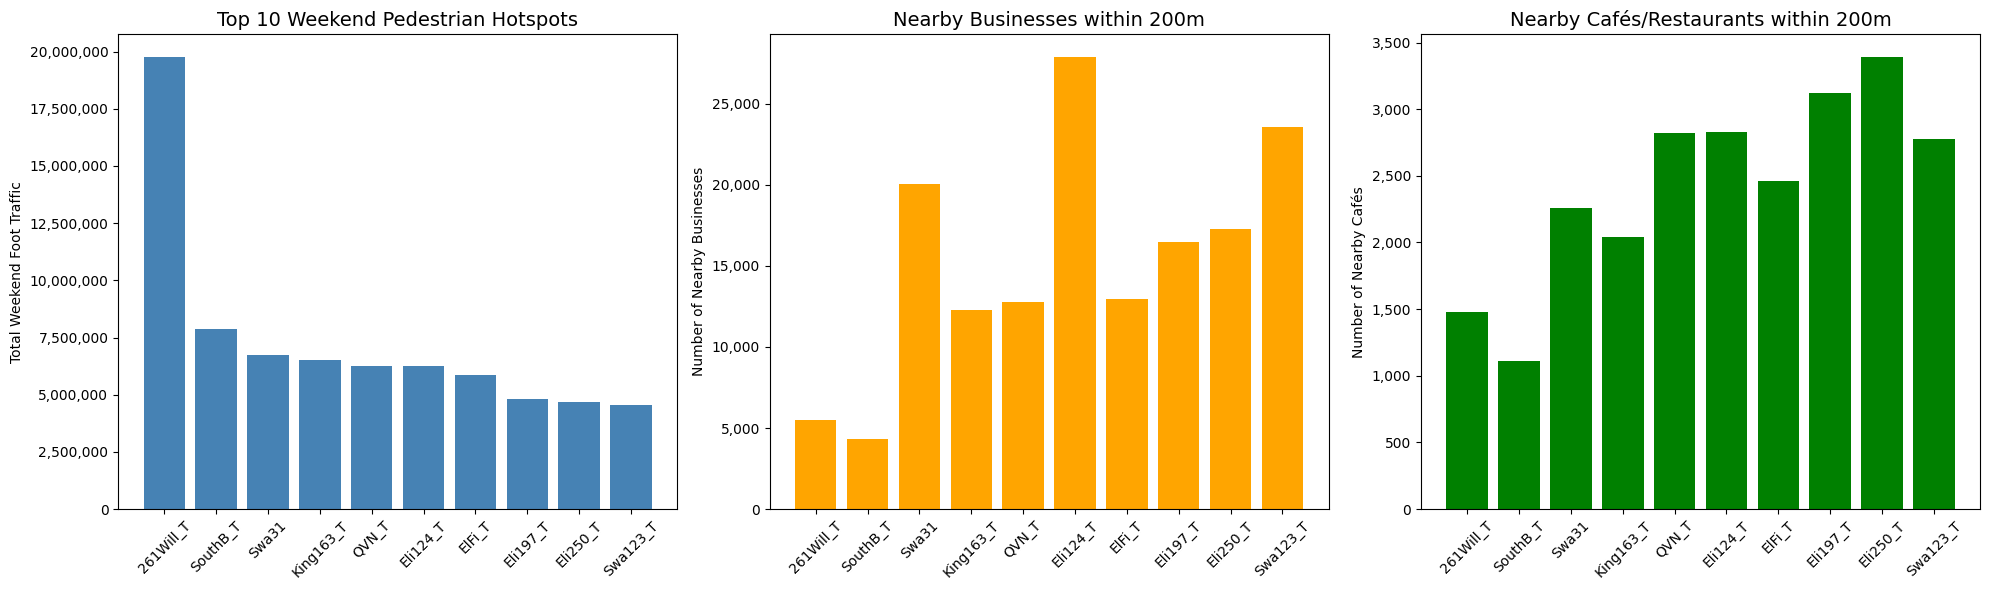

In [15]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Calculate nearby cafés count for each hotspot
cafe_counts = []
for _, sensor in top10_weekend.iterrows():
    subset_cafes = cafes_df[
        (cafes_df['latitude']  >= sensor['latitude']-0.002) &
        (cafes_df['latitude']  <= sensor['latitude']+0.002) &
        (cafes_df['longitude'] >= sensor['longitude']-0.002) &
        (cafes_df['longitude'] <= sensor['longitude']+0.002)
    ]
    distances = haversine_np(sensor['latitude'], sensor['longitude'],
                             subset_cafes['latitude'].values, subset_cafes['longitude'].values)
    cafe_counts.append((distances <= 200).sum())

top10_weekend['nearby_cafes'] = cafe_counts

# --- Create 3 subplots ---
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# 1: Foot traffic
axes[0].bar(top10_weekend['sensor_name'], top10_weekend['total_weekend_count'], color='steelblue')
axes[0].set_title("Top 10 Weekend Pedestrian Hotspots", fontsize=14)
axes[0].set_ylabel("Total Weekend Foot Traffic")
axes[0].tick_params(axis='x', rotation=45)
axes[0].yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

# 2: Nearby businesses
axes[1].bar(top10_weekend['sensor_name'], top10_weekend['nearby_businesses'], color='orange')
axes[1].set_title("Nearby Businesses within 200m", fontsize=14)
axes[1].set_ylabel("Number of Nearby Businesses")
axes[1].tick_params(axis='x', rotation=45)
axes[1].yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

# 3: Nearby cafés
axes[2].bar(top10_weekend['sensor_name'], top10_weekend['nearby_cafes'], color='green')
axes[2].set_title("Nearby Cafés/Restaurants within 200m", fontsize=14)
axes[2].set_ylabel("Number of Nearby Cafés")
axes[2].tick_params(axis='x', rotation=45)
axes[2].yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

plt.tight_layout()
plt.show()


**Business Composition in Busiest Weekend Location**

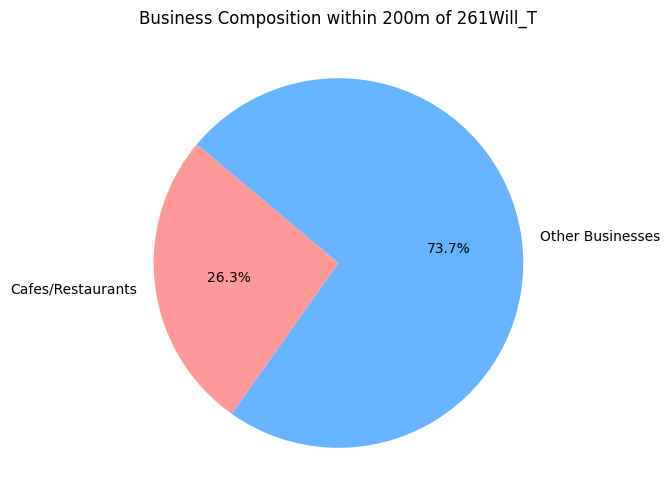

261Will_T has 1479 cafes/restaurants out of 5618 total businesses nearby.


In [16]:


# 1. Get busiest location details
busiest_lat = top10_weekend.iloc[0]['latitude']
busiest_lon = top10_weekend.iloc[0]['longitude']
busiest_name = top10_weekend.iloc[0]['sensor_name']

# 2. Filter all businesses within 200m of this location
distances_all = haversine_np(
    busiest_lat, busiest_lon,
    business_df['latitude'].values,
    business_df['longitude'].values
)
nearby_all_businesses = business_df[distances_all <= 200]

# 3. Load cafés dataset if not already loaded
CAFES_DATASET = 'cafes-and-restaurants-with-seating-capacity'
cafes_df = fetch_dataset_csv(BASE_URL, CAFES_DATASET, API_KEY)

# Convert coordinates to numeric for cafés dataset
cafes_df['latitude'] = pd.to_numeric(cafes_df['latitude'], errors='coerce')
cafes_df['longitude'] = pd.to_numeric(cafes_df['longitude'], errors='coerce')
cafes_df = cafes_df.dropna(subset=['latitude', 'longitude'])

# 4. Filter cafes/restaurants within 200m
distances_cafes = haversine_np(
    busiest_lat, busiest_lon,
    cafes_df['latitude'].values,
    cafes_df['longitude'].values
)
nearby_cafes = cafes_df[distances_cafes <= 200]

# 5. Prepare counts for pie chart
cafe_count = len(nearby_cafes)
other_count = len(nearby_all_businesses) - cafe_count

# 6. Plot pie chart
plt.figure(figsize=(6, 6))
plt.pie(
    [cafe_count, other_count],
    labels=['Cafes/Restaurants', 'Other Businesses'],
    autopct='%1.1f%%',
    startangle=140,
    colors=['#ff9999','#66b3ff']
)
plt.title(f"Business Composition within 200m of {busiest_name}")
plt.show()

print(f"{busiest_name} has {cafe_count} cafes/restaurants out of {len(nearby_all_businesses)} total businesses nearby.")


**Top 5 Cafes/Restaurants near the busiest location**

In [17]:

if 'trading_name' in cafes_df.columns:
    top5_cafes = nearby_cafes[['trading_name', 'seating_type', 'number_of_seats', 'latitude', 'longitude']].head(5)
elif 'business_name' in cafes_df.columns:
    top5_cafes = nearby_cafes[['business_name', 'latitude', 'longitude']].head(5)
else:
    top5_cafes = nearby_cafes.head(5)

print(f"\nTop 5 Cafes/Restaurants within 200m of {busiest_name}:\n")
for idx, row in top5_cafes.iterrows():
    name = row.get('trading_name', row.get('business_name', 'Unknown'))
    seats = row.get('number_of_seats', 'N/A')
    seat_info = f" – {seats} seats" if seats != 'N/A' else ""
    print(f"- {name}{seat_info}")



Top 5 Cafes/Restaurants within 200m of 261Will_T:

- Suda – 8 seats
- The Mint Bar & Restaurant – 48 seats
- Schmucks Bagels – 18 seats
- Paik's Bbq – 72 seats
- Sinjeon Food System – 8 seats


Visualisation of Hotspots and Nearby Business Context (Interactive Map)

Map popups show weekend foot traffic, total businesses within 200 m, and example cafés.

In [21]:


from branca.element import Template, MacroElement


try:
    cafes_df
except NameError:
    CAFES_DATASET = 'cafes-and-restaurants-with-seating-capacity'
    cafes_df = fetch_dataset_csv(BASE_URL, CAFES_DATASET, API_KEY)

cafes_df['latitude']  = pd.to_numeric(cafes_df['latitude'], errors='coerce')
cafes_df['longitude'] = pd.to_numeric(cafes_df['longitude'], errors='coerce')
cafes_df = cafes_df.dropna(subset=['latitude','longitude']).copy()


name_cols = [c for c in cafes_df.columns if c.lower() in ['trading_name','business_name','name','organisation']]
if name_cols:
    cafes_df = cafes_df.rename(columns={name_cols[0]: 'business_name'})
else:
    cafes_df['business_name'] = "Unnamed Café/Restaurant"


def nearby_cafe_names(lat0, lon0, max_names=3, radius_m=200):
    box = cafes_df[
        (cafes_df['latitude']  >= lat0-0.002) &
        (cafes_df['latitude']  <= lat0+0.002) &
        (cafes_df['longitude'] >= lon0-0.002) &
        (cafes_df['longitude'] <= lon0+0.002)
    ]
    if box.empty:
        return "—"
    d = haversine_np(lat0, lon0, box['latitude'].values, box['longitude'].values)
    close = box[d <= radius_m]
    if close.empty:
        return "—"
    names = close['business_name'].dropna().astype(str).head(max_names).tolist()
    return ", ".join(names) if names else "—"


if 'nearby_cafes' not in top10_weekend.columns:
    cafe_counts = []
    for _, s in top10_weekend.iterrows():
        sub = cafes_df[
            (cafes_df['latitude']  >= s['latitude']-0.002) &
            (cafes_df['latitude']  <= s['latitude']+0.002) &
            (cafes_df['longitude'] >= s['longitude']-0.002) &
            (cafes_df['longitude'] <= s['longitude']+0.002)
        ]
        d = haversine_np(s['latitude'], s['longitude'], sub['latitude'].values, sub['longitude'].values)
        cafe_counts.append(int((d <= 200).sum()))
    top10_weekend['nearby_cafes'] = cafe_counts


melbourne_map2 = folium.Map(location=[-37.8136, 144.9631], zoom_start=13)

for _, row in top10_weekend.iterrows():
    cafe_examples = nearby_cafe_names(row['latitude'], row['longitude'])


    if row['nearby_cafes'] >= 50:
        marker_color = 'darkgreen'
    elif row['nearby_cafes'] >= 20:
        marker_color = 'orange'
    else:
        marker_color = 'lightblue'


    if cafe_examples and cafe_examples != "—":
        li_items = "".join(f"<li>{n}</li>" for n in cafe_examples.split(", "))
        cafes_list_html = f"<b>Nearby cafés (≤200m):</b><ul style='margin:4px 0 0 18px;'>{li_items}</ul>"
    else:
        cafes_list_html = "<b>Nearby cafés (≤200m):</b> —"

    popup_text = (
        f"<b>{row['sensor_name']}</b><br>"
        f"Weekend Foot Traffic: {int(row['total_weekend_count']):,}<br>"
        f"Nearby Businesses (≤200m): {int(row['nearby_businesses']):,}<br>"
        f"Nearby Cafés (≤200m): {int(row['nearby_cafes']):,}<br>"
        f"{cafes_list_html}"
    )

    folium.Marker(
        location=[row['latitude'], row['longitude']],
        popup=popup_text,
        icon=folium.Icon(color=marker_color, icon='briefcase')
    ).add_to(melbourne_map2)


legend_html = """
{% macro html(this, kwargs) %}
<div style="
    position: fixed; bottom: 50px; left: 50px;
    width: 220px; z-index:9999; font-size:14px;
    background-color: white; border:2px solid grey; border-radius:8px; padding: 10px;">
<b>Café Density Legend</b><br>
<i class="fa fa-map-marker fa-2x" style="color:darkgreen"></i> 50+ cafés<br>
<i class="fa fa-map-marker fa-2x" style="color:orange"></i> 20–49 cafés<br>
<i class="fa fa-map-marker fa-2x" style="color:lightblue"></i> <20 cafés
</div>
{% endmacro %}
"""
legend = MacroElement()
legend._template = Template(legend_html)
melbourne_map2.get_root().add_child(legend)


melbourne_map2


**Business-First Insights**

We summarise the key weekend hotspots with business presence for decision-making.

In [24]:


print("\n--- Weekend Business Activity Insights ---\n")

# Busiest location
busiest = top10_weekend.iloc[0]
print(f"- Busiest weekend location: {busiest['sensor_name']} "
      f"with {fmt_int(busiest['total_weekend_count'])} people.")

# Top 3 locations
print("\n- Top 3 weekend hotspots (with nearby businesses & café examples):")
for i in range(min(3, len(top10_weekend))):
    r = top10_weekend.iloc[i]
    cafes = r.get('example_cafes', '—') or '—'
    print(f"  {i+1}. {r['sensor_name']} – {fmt_int(r['total_weekend_count'])} people; "
          f"{fmt_int(r.get('nearby_businesses', 0))} businesses; Cafés: {cafes}")

# Recommendations
print("\n- Recommendations:")
print("  • Extend weekend opening hours in identified hotspots.")
print("  • Run targeted weekend promotions where both footfall and business presence are high.")
print("  • Consider pop-ups/events within ≤200 m of top sensors to capture leisure traffic.")



--- Weekend Business Activity Insights ---

- Busiest weekend location: 261Will_T with 19,769,157 people.

- Top 3 weekend hotspots (with nearby businesses & café examples):
  1. 261Will_T – 19,769,157 people; 5,504 businesses; Cafés: Suda, The Mint Bar & Restaurant, Schmucks Bagels
  2. SouthB_T – 7,869,523 people; 4,292 businesses; Cafés: Joy Cupcakes, Pho Flinders, Boost Juice
  3. Swa31 – 6,744,981 people; 20,034 businesses; Cafés: Centro Espresso Caffe, Eurolane Cafe, Ganache Chocolate Lounge

- Recommendations:
  • Extend weekend opening hours in identified hotspots.
  • Run targeted weekend promotions where both footfall and business presence are high.
  • Consider pop-ups/events within ≤200 m of top sensors to capture leisure traffic.


**Conclusion**

This business-first analysis connects weekend pedestrian demand with nearby business supply. It highlights where the city is busiest on weekends and what commercial presence exists around those locations, supporting decisions on rostering, promotions, and event activation.

**Observations**

Top weekend hotspots cluster around well-known CBD corridors where business density is high.
Named cafés near hotspots provide tangible examples for campaign or partnership targeting.
Some high-footfall areas have fewer nearby businesses, indicating potential gaps/opportunities.

**Recommendations**

Prioritise weekend staffing and extended hours around the busiest sensors.
Activate local marketing (offers, street promotions) within ≤200 m of top hotspots.
Partner with nearby cafés for co-promotions during peak weekend hours.
Trial pop-ups in high-footfall zones with relatively lower business counts to test demand.
Limitations

The general Business Establishments export here does not include names; we therefore added a cafés dataset to provide named examples.
The 200 m radius is a practical default; results will vary with smaller/larger radii.
Sensor counts reflect the immediate area; micro-location effects (laneways, arcades) may differ.
Future Work

Add other named industry datasets (e.g., bars/pubs, retail outlets) for richer examples.
Segment weekend time-of-day patterns (morning vs evening peaks).
Test 100 m/300 m radii and compare business impact metrics.

**Export**

Save the final ranked hotspots with business counts and example cafés for reporting.

In [25]:
out = top10_weekend[['sensor_name','latitude','longitude',
                     'total_weekend_count','nearby_businesses','example_cafes']].copy()
out.to_csv("Top10_Weekend_BusinessImpact.csv", index=False)
print("Saved:", "Top10_Weekend_BusinessImpact.csv")


Saved: Top10_Weekend_BusinessImpact.csv
